## Qiskit code for "Digital quantum simulation of bosonic systems and quantum complementarity"
### Victor P. Brasil, Diego S. Starke and Jonas Maziero
---
#


In [1]:
from numpy import *
import numpy as np
from qiskit import *
from qiskit_aer import AerSimulator; 
from qiskit_ibm_runtime import *
from qiskit.transpiler.preset_passmanagers import *
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.visualization import *
import matplotlib.pyplot as plt

backend_name = 'ibm_kyiv'
service = QiskitRuntimeService()
backend = service.backend(backend_name)

simulator = AerSimulator()
pm = generate_preset_pass_manager(backend=simulator, optimization_level=3)

###########'simulator' / 'backend'
sampler = Sampler(mode = simulator) 
#################################
sampler.options.default_shots = 2**13
nshots = sampler.options.default_shots 

# pm = generate_preset_pass_manager(backend=aer, optimization_level=3)
# sampler = Sampler(mode=aer)
# sampler.options.default_shots = 2**13
# nshots = sampler.options.default_shots  

In [2]:
def results(counts_theo:dict, counts_sim:dict, counts_exp:dict, name:str):
    
    keys_theo = sorted(counts_theo.keys())
    keys_sim = sorted(counts_sim.keys())
    keys_exp = sorted(counts_exp.keys())

    probs_counts_theo = []
    probs_counts_sim = []
    probs_counts_exp = []

    for k in range(len(keys_theo)):
        probs_counts_theo.append(round(counts_theo[keys_theo[k]] / nshots, 3))
    
    for k in range(len(keys_sim)):
        probs_counts_sim.append(round(counts_sim[keys_sim[k]] / nshots, 3))
    
    for k in range(len(keys_exp)):
        probs_counts_exp.append(round(counts_exp[keys_exp[k]] / nshots, 3))
    
    counts_label = [] 
    for j in range(len(keys_exp)):
        counts_label.append(keys_exp[j])
    
    values = arange(len(counts_label))*2
    
    fig, ax = plt.subplots(layout='constrained')

    plt.rcParams['hatch.linewidth'] = 0.5

    plt.rcParams['mathtext.fontset'] = 'cm'

    plt.subplot().bar(values-0.4, probs_counts_theo, color='cornflowerblue', width=0.4, hatch='///', 
                      edgecolor='black', linewidth=0)
    plt.subplot().bar(values-0.4, probs_counts_theo, color='none', width=0.4, edgecolor='cornflowerblue')
    
    
    plt.subplot().bar(values, probs_counts_sim, color='slateblue', width=0.4, hatch='\\', edgecolor='black',
                     linewidth=0) 
    plt.subplot().bar(values, probs_counts_sim, color='none', width=0.4, edgecolor='slateblue') 
    
    
    plt.subplot().bar(values+0.4, probs_counts_exp, color='indigo', width=0.4) 

    ax.margins(0.1)
    
    plt.xticks(rotation=45)
    
    plt.xticks(values, counts_label)
    
    for c in ax.containers:
        labels = [v if v > 0 else "" for v in c.datavalues]    
        ax.bar_label(c, labels=labels, padding=7)
    
    plt.ylabel('Probability', size=14)

    return plt.show()

def add_keys(counts_sim, counts_exp):
    keys = sorted(counts_exp.keys())

    for j in range(0, len(keys)):
        if keys[j] not in counts_sim:
            counts_sim[keys[j]] = 0 
        else:
            pass

In [4]:
def XX(theta): 
    qc = QuantumCircuit(2, name=' '+r'$X \otimes X$'+' ')   
    qc.h([0,1]); qc.cx(0, 1)
    qc.rz(-2*theta, [1])
    qc.cx(0, 1); qc.h([0,1])
    return qc

def YY(theta): 
    qc = QuantumCircuit(2, name=' '+r'$Y \otimes Y$'+' ')   
    qc.sdg([0, 1]); qc.h([0, 1]); qc.cx(0, 1)
    qc.rz(-2*theta, [1])
    qc.cx(0, 1); qc.h([0, 1]); qc.s([0, 1])
    return qc

def beam_splitter():
    bs = QuantumCircuit(2, name='   '+r'$U_{BS}$'+'   ')
    bs.append(XX(pi/8), [[0], [1]])
    bs.append(YY(pi/8), [[0], [1]])
    return bs

def mirror():
    bs = QuantumCircuit(2, name='   '+r'$U_{M}$'+'   ')
    bs.append(XX(pi/4), [[0], [1]])
    bs.append(YY(pi/4), [[0], [1]])
    return bs

def biased_beam_splitter(theta):
    bbs = QuantumCircuit(2, name='   '+r'$U_{BBS}$'+'   ')
    bbs.append(XX(0.5*theta), [[0], [1]])
    bbs.append(YY(0.5*theta), [[0], [1]])
    return bbs

###
---
###

## I. Unruh's experiment setups

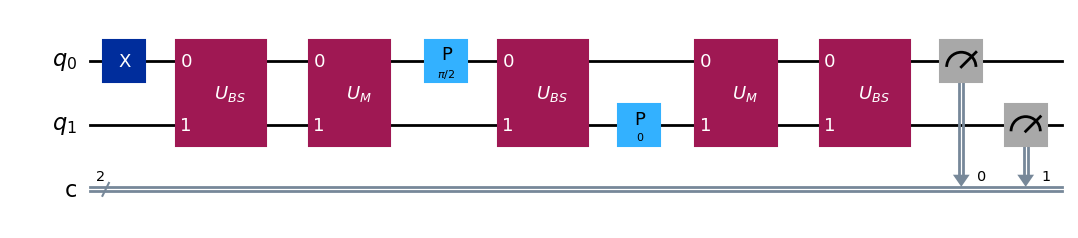

In [5]:
unruh_1 = QuantumCircuit(2, 2)
unruh_1.x(0)
unruh_1.append(beam_splitter(), [[0], [1]])
unruh_1.append(mirror(), [[0], [1]])
unruh_1.p(np.pi/2, 0)
unruh_1.append(beam_splitter(), [[0], [1]])
unruh_1.p(0, 1)
unruh_1.append(mirror(), [[0], [1]])
unruh_1.append(beam_splitter(), [[0], [1]])
unruh_1.measure([0, 1], [0, 1])
unruh_1.draw('mpl')

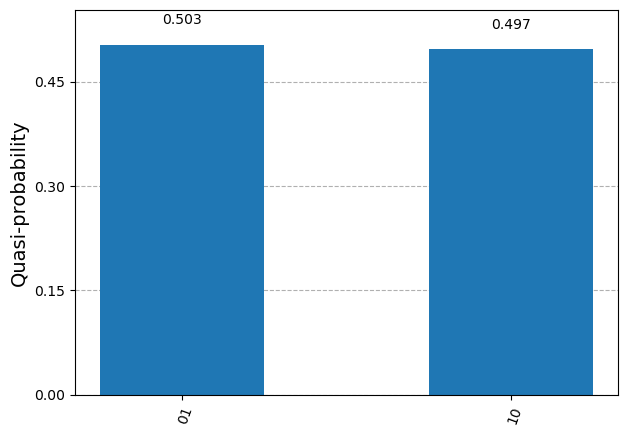

In [34]:
### simulation

sampler = Sampler(mode = simulator) 
sampler.options.default_shots = 2**13
nshots = sampler.options.default_shots 
unruh_1 = transpile(unruh_1, simulator, optimization_level=3)
job_unruh_1 = sampler.run([unruh_1]).result() 
counts_sim_unruh_1 = job_unruh_1[0].data.c.get_counts() 
plot_distribution(counts_sim_unruh_1)

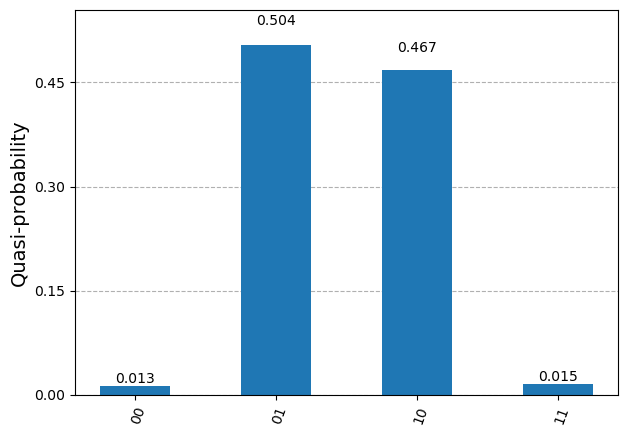

In [30]:
### demonstration

sampler = Sampler(mode=backend)
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.default_shots = 2**13
nshots = sampler.options.default_shots 
job_exp_1 = sampler.run([transpile(unruh_1, backend, optimization_level=3)]).result()
counts_exp_1 = job_exp_1[0].data.c.get_counts() 
plot_distribution(counts_exp_1)

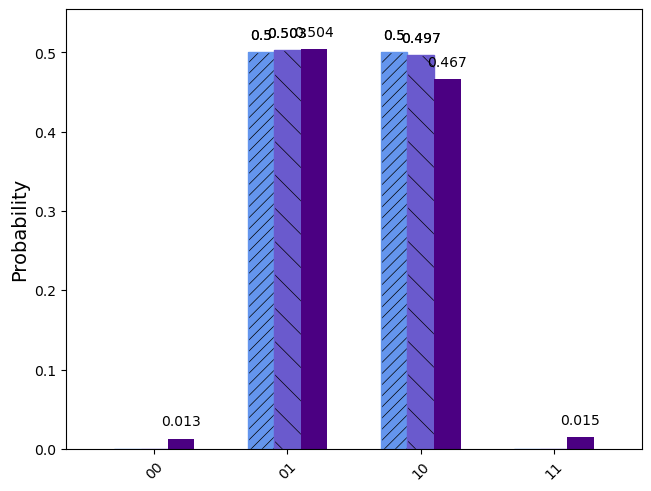

In [6]:
counts_theo_unruh_1 = {'01':2**13/2, '10':2**13/2, '00':0, '11':0}

counts_sim_unruh_1 = {'01': 4120, '10': 4072, '00':0, '11':0}

counts_dem_unruh_1 = {'01': 4130, '10': 3829, '11': 125, '00': 108} # extracted from counts_exp_1

results(counts_theo_unruh_1, counts_sim_unruh_1, counts_dem_unruh_1, name='unruh_1')

#
---
#

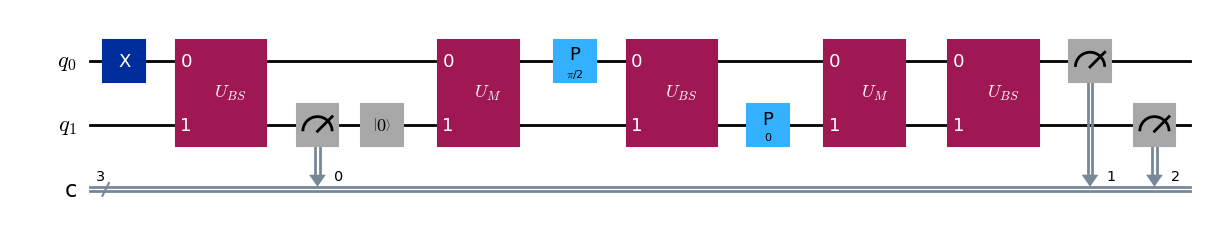

In [27]:
unruh_2 = QuantumCircuit(2, 3)
unruh_2.x(0)
unruh_2.append(beam_splitter(), [[0], [1]])
unruh_2.measure(1, 0)
unruh_2.reset(1)
unruh_2.append(mirror(), [[0], [1]])
unruh_2.p(np.pi/2, 0)
unruh_2.append(beam_splitter(), [[0], [1]])
unruh_2.p(0, 1)
unruh_2.append(mirror(), [[0], [1]])
unruh_2.append(beam_splitter(), [[0], [1]])
unruh_2.measure([0, 1], [1, 2])
unruh_2.draw('mpl')

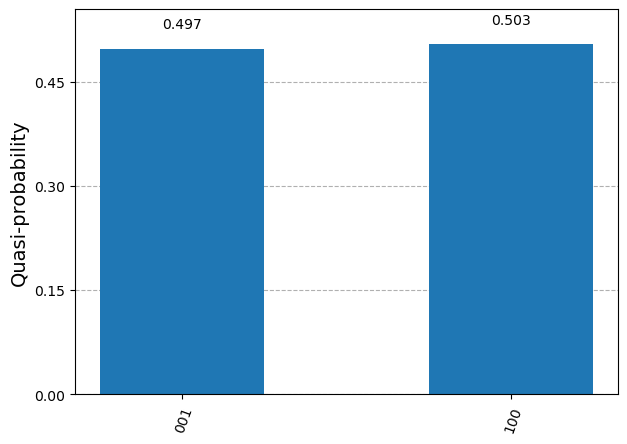

In [37]:
### simulation

sampler = Sampler(mode = simulator) 
sampler.options.default_shots = 2**13
nshots = sampler.options.default_shots 
unruh_2 = transpile(unruh_2, simulator, optimization_level=3)
job_unruh_2 = sampler.run([unruh_2]).result() 
counts_sim_unruh_2 = job_unruh_2[0].data.c.get_counts() 
plot_distribution(counts_sim_unruh_2)

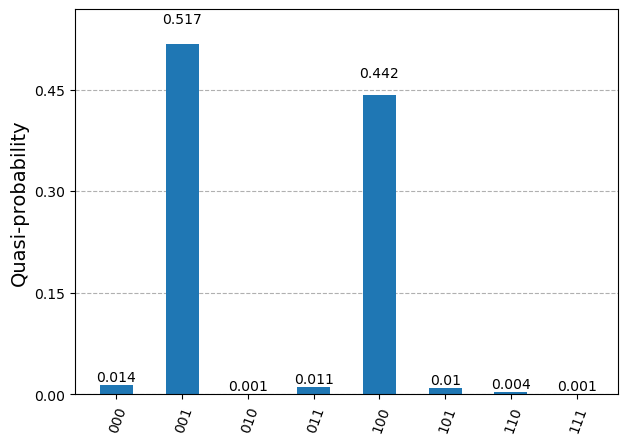

In [32]:
### demonstration

sampler = Sampler(mode=backend)
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.default_shots = 2**13
nshots = sampler.options.default_shots 
job_dem_unruh_2 = sampler.run([transpile(unruh_2, backend, optimization_level=3)]).result()
counts_dem_unruh_2 = job_dem_unruh_2[0].data.c.get_counts() 
plot_distribution(counts_dem_unruh_2)

In [43]:
counts_theo_unruh_2 = {'000':0, '001':2**13/2, '010':0, '011':0, '100':2**13/2, '101':0, '110':0, '111':0}

counts_sim_unruh_2 = {'001': 4069, '100': 4123}

counts_dem_unruh_2 = {'100': 3619,
                     '001': 4235,
                     '011': 88,
                     '110': 35,
                     '101': 78,
                     '010': 9,
                     '000': 118,
                     '111': 10}

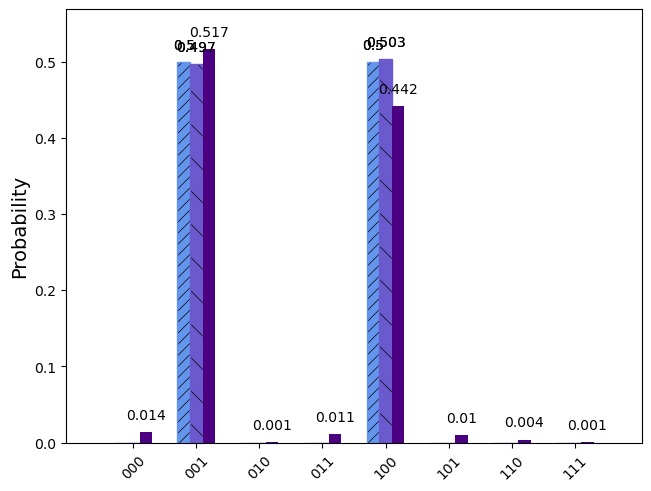

In [50]:
add_keys(counts_sim_unruh_2, counts_dem_unruh_2)

results(counts_theo_unruh_2, counts_sim_unruh_2, counts_dem_unruh_2, 'unruh_2')

#
---
#

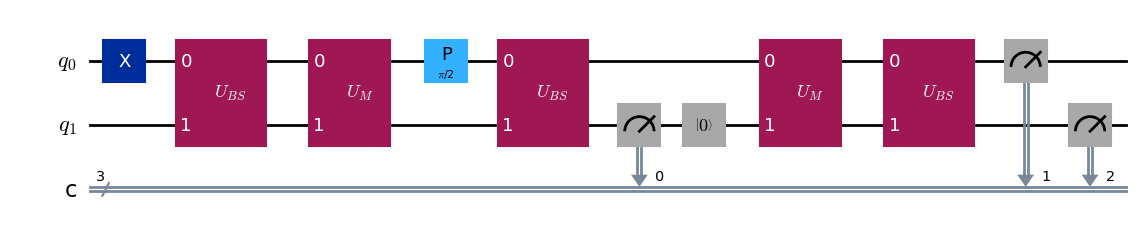

In [46]:
unruh_3 = QuantumCircuit(2, 3)
unruh_3.x(0)
unruh_3.append(beam_splitter(), [[0], [1]])
unruh_3.append(mirror(), [[0], [1]])
unruh_3.p(np.pi/2, 0)
unruh_3.append(beam_splitter(), [[0], [1]])
unruh_3.measure(1, 0)
unruh_3.reset(1)
unruh_3.append(mirror(), [[0], [1]])
unruh_3.append(beam_splitter(), [[0], [1]])
unruh_3.measure([0, 1], [1, 2])
unruh_3.draw('mpl')

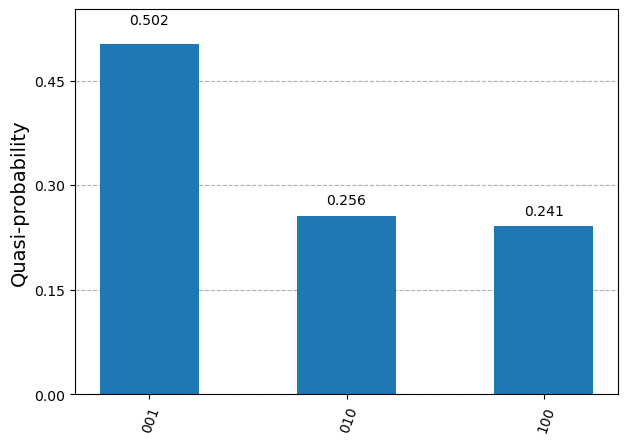

In [47]:
### simulation

sampler = Sampler(mode = simulator) 
sampler.options.default_shots = 2**13
nshots = sampler.options.default_shots 
unruh_3 = transpile(unruh_3, simulator, optimization_level=3)
job_unruh_3 = sampler.run([unruh_3]).result() 
counts_sim_unruh_3 = job_unruh_3[0].data.c.get_counts() 
plot_distribution(counts_sim_unruh_3)

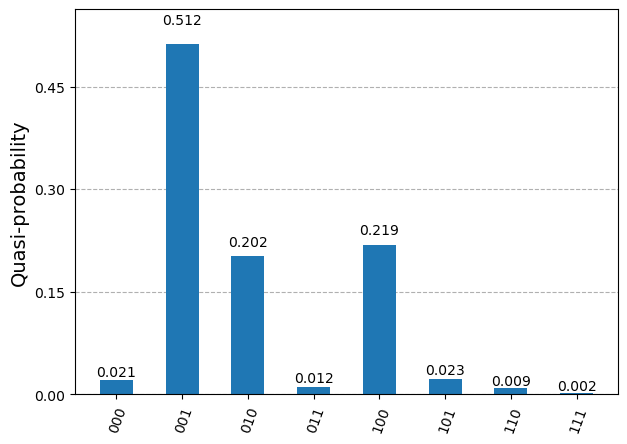

In [56]:
### demonstration

sampler = Sampler(mode=backend)
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.default_shots = 2**13
nshots = sampler.options.default_shots 
job_dem_unruh_3 = sampler.run([transpile(unruh_3, backend, optimization_level=3)]).result()
counts_dem_unruh_3 = job_dem_unruh_3[0].data.c.get_counts() 
plot_distribution(counts_dem_unruh_3)

In [49]:
counts_theo_unruh_3 = {'010': 2**13/4,
                 '001': 2**13/2,
                 '100': 2**13/4,
                 '101': 0,
                 '011': 0,
                 '000': 0,
                 '111': 0,
                 '110': 0}

counts_sim_unruh_3 = {'001': 4115, '100': 1977, '010': 2100}

counts_dem_unruh_3 = {'001': 4195,
                     '100': 1790,
                     '101': 186,
                     '010': 1657,
                     '011': 95,
                     '000': 172,
                     '111': 20,
                     '110': 77}

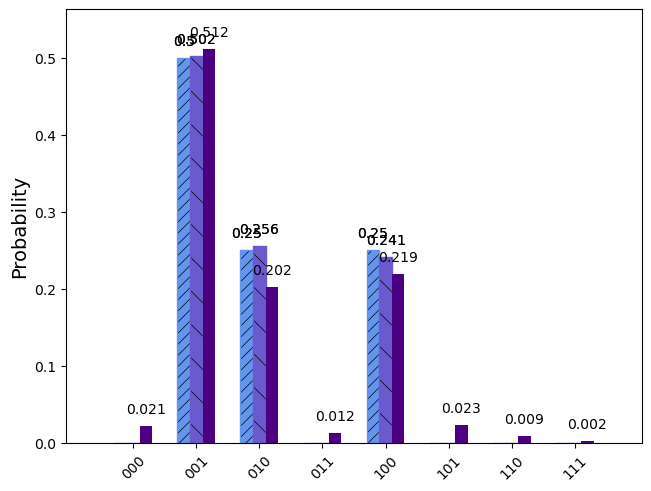

In [51]:
add_keys(counts_sim_unruh_3, counts_dem_unruh_3)

results(counts_theo_unruh_3, counts_sim_unruh_3, counts_dem_unruh_3, 'unruh_3')

#
---
#

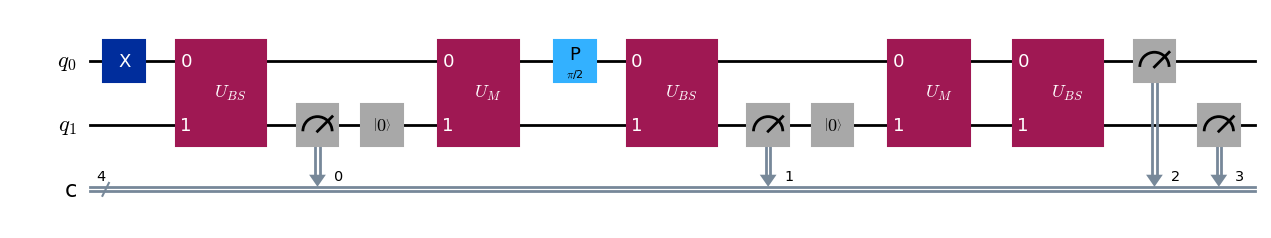

In [53]:
unruh_4 = QuantumCircuit(2, 4)
unruh_4.x(0)
unruh_4.append(beam_splitter(), [[0], [1]])
unruh_4.measure(1, 0)
unruh_4.reset(1)
unruh_4.append(mirror(), [[0], [1]])
unruh_4.p(np.pi/2, 0)
unruh_4.append(beam_splitter(), [[0], [1]])
unruh_4.measure(1, 1)
unruh_4.reset(1)
unruh_4.append(mirror(), [[0], [1]])
unruh_4.append(beam_splitter(), [[0], [1]])
unruh_4.measure(0, 2) 
unruh_4.measure(1, 3)
unruh_4.draw('mpl')

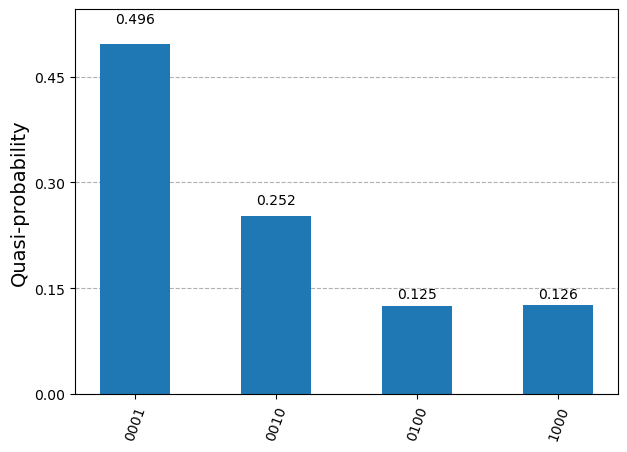

In [54]:
### simulation

sampler = Sampler(mode = simulator) 
sampler.options.default_shots = 2**13
nshots = sampler.options.default_shots 
unruh_4 = transpile(unruh_4, simulator, optimization_level=3)
job_unruh_4 = sampler.run([unruh_4]).result() 
counts_sim_unruh_4 = job_unruh_4[0].data.c.get_counts() 
plot_distribution(counts_sim_unruh_4)

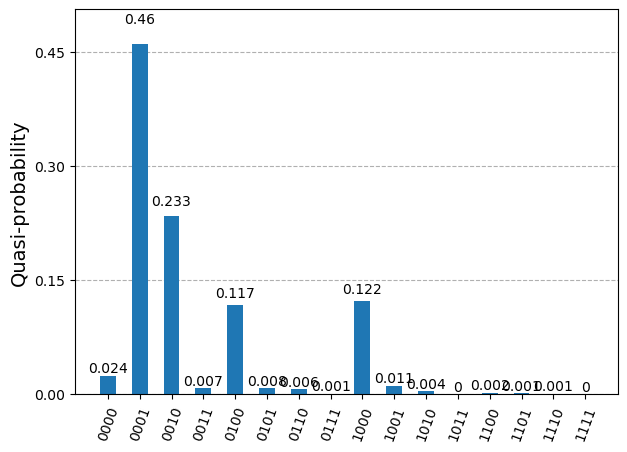

In [75]:
### demonstration

sampler = Sampler(mode=backend)
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.default_shots = 2**13
nshots = sampler.options.default_shots 
job_dem_unruh_4 = sampler.run([transpile(unruh_4, backend, optimization_level=3)]).result()
counts_dem_unruh_4 = job_dem_unruh_4[0].data.c.get_counts() 
plot_distribution(counts_dem_unruh_4)

In [57]:
counts_theo_unruh_4 = {'0001': 2**13/2,
                 '0000': 0,
                 '0100': 2**13/8,
                 '0010': 2**13/4,
                 '1000': 2**13/8,
                 '1001': 0,
                 '1010': 0,
                 '0110': 0,
                 '0101': 0,
                 '0011': 0,
                 '1011': 0,
                 '1110': 0,
                 '1100': 0,
                 '1111': 0,
                 '0111': 0,
                 '1101': 0}

counts_sim_unruh_4 = {'0010': 2068, '1000': 1034, '0001': 4063, '0100': 1027}

counts_dem_unruh_4 = {'0001': 3767,
                 '0000': 200,
                 '0100': 960,
                 '0010': 1912,
                 '1000': 1003,
                 '1001': 91,
                 '1010': 36,
                 '0110': 52,
                 '0101': 66,
                 '0011': 61,
                 '1011': 3,
                 '1110': 6,
                 '1100': 17,
                 '1111': 2,
                 '0111': 5,
                 '1101': 11}

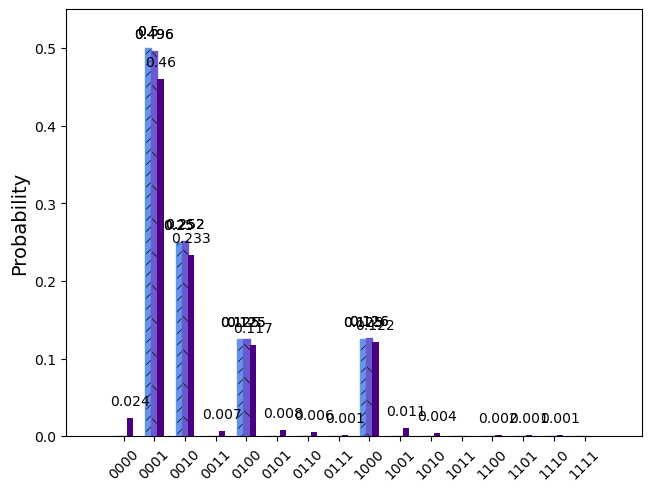

In [58]:
add_keys(counts_sim_unruh_4, counts_dem_unruh_4)

results(counts_theo_unruh_4, counts_sim_unruh_4, counts_dem_unruh_4, 'unruh_4')

#
---
#

## II. Pessoa's experiment setups

In [7]:
np.arctan(0.2/0.98)

0.20131710837464076

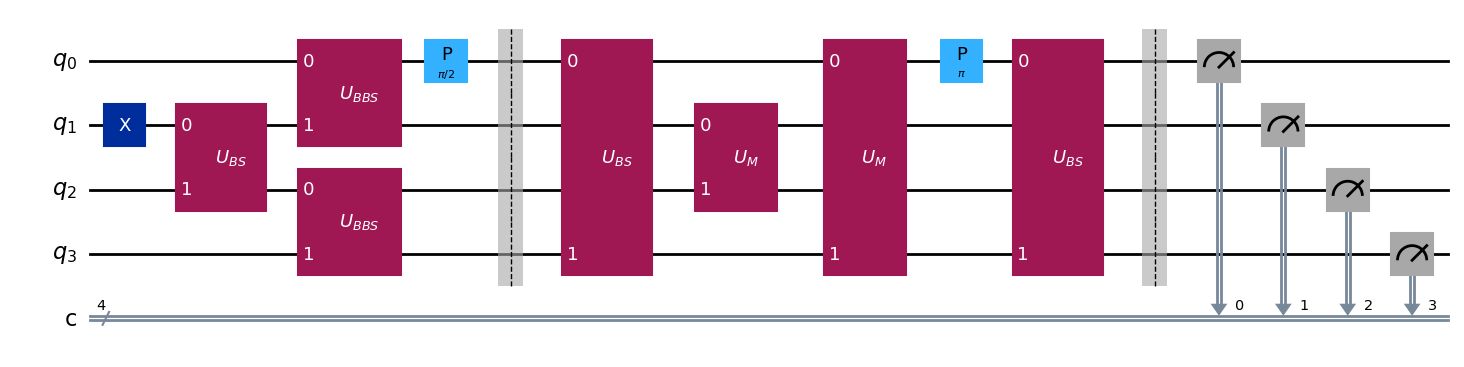

In [5]:
p1 = QuantumCircuit(4, 4)
p1.x(1)
p1.append(beam_splitter(), [[1], [2]]) 
p1.append(biased_beam_splitter(0.20131710837464076), [[0], [1]])
p1.append(biased_beam_splitter(0.20131710837464076), [[2], [3]])
p1.p(np.pi/2, 0)
p1.barrier()
p1.append(beam_splitter(), [[0], [3]]) 
p1.append(mirror(), [[1], [2]]) 
p1.append(mirror(), [[0], [3]]) 
p1.p(pi, 0)
p1.append(beam_splitter(), [[0], [3]]) 
p1.barrier()
p1.measure([0, 1, 2, 3], [0, 1, 2, 3])
p1.draw('mpl')

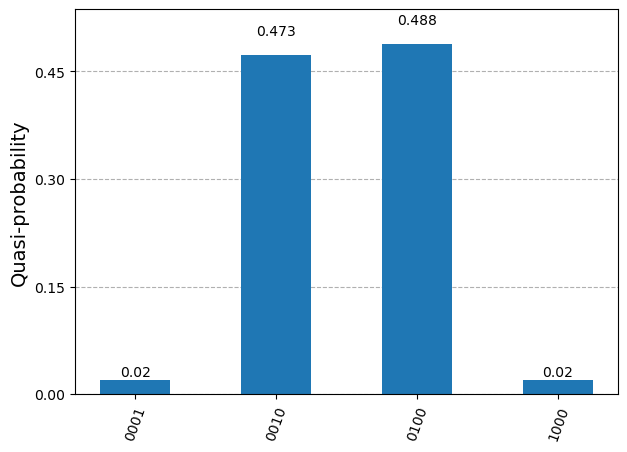

In [6]:
### simulation

sampler = Sampler(mode = simulator) 
sampler.options.default_shots = 2**13
nshots = sampler.options.default_shots 
p1 = transpile(p1, simulator, optimization_level=3)
job_p1 = sampler.run([p1]).result() 
counts_sim_p1 = job_p1[0].data.c.get_counts() 
plot_distribution(counts_sim_p1)

### $p(D_1) = 0.02 + 0.474 = 0.494$
### $p(D_0) = 0.484 + 0.021 = 0.505$

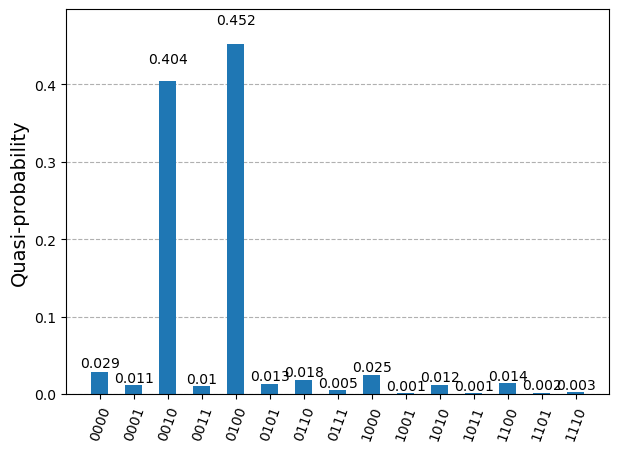

In [14]:
### demonstration

sampler = Sampler(mode=backend)
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.default_shots = 2**13
nshots = sampler.options.default_shots 
job_dem_p1 = sampler.run([transpile(p1, backend, optimization_level=3)]).result()
counts_dem_p1 = job_dem_p1[0].data.c.get_counts() 
plot_distribution(counts_dem_p1)

In [60]:
counts_dem_p1 = {'0010': 3309,
                 '1000': 205,
                 '0100': 3704,
                 '0101': 105,
                 '1101': 14,
                 '0000': 235,
                 '0111': 42,
                 '0011': 81,
                 '1010': 99,
                 '0001': 94,
                 '0110': 149,
                 '1100': 115,
                 '1011': 7,
                 '1110': 23,
                 '1001': 10}

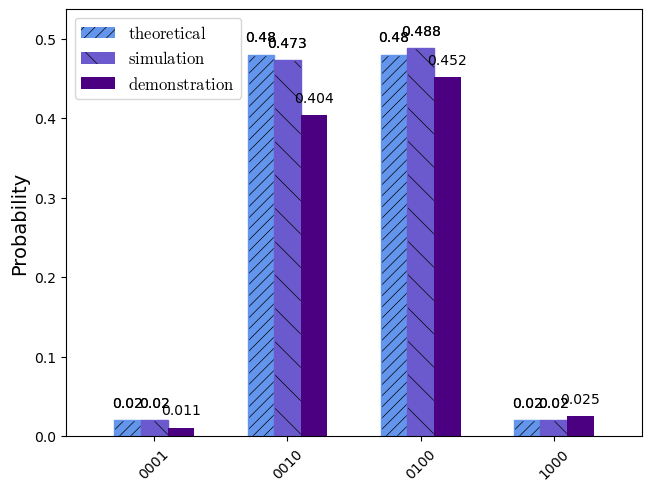

In [15]:
counts_theo_p1 = {'0001': 0.02*2**13, '0010': 0.48*2**13, '0100': 0.48*2**13, '1000':0.02*2**13}

counts_sim_p1 = {'0001': 160, '0010': 3873, '0100': 3998, '1000': 161}

counts_dem_p1_ajusted = {'0001': 94, '0010': 3309, '0100': 3704, '1000': 205}

results(counts_theo_p1, counts_sim_p1, counts_dem_p1_ajusted, 'p1')

#
---
#

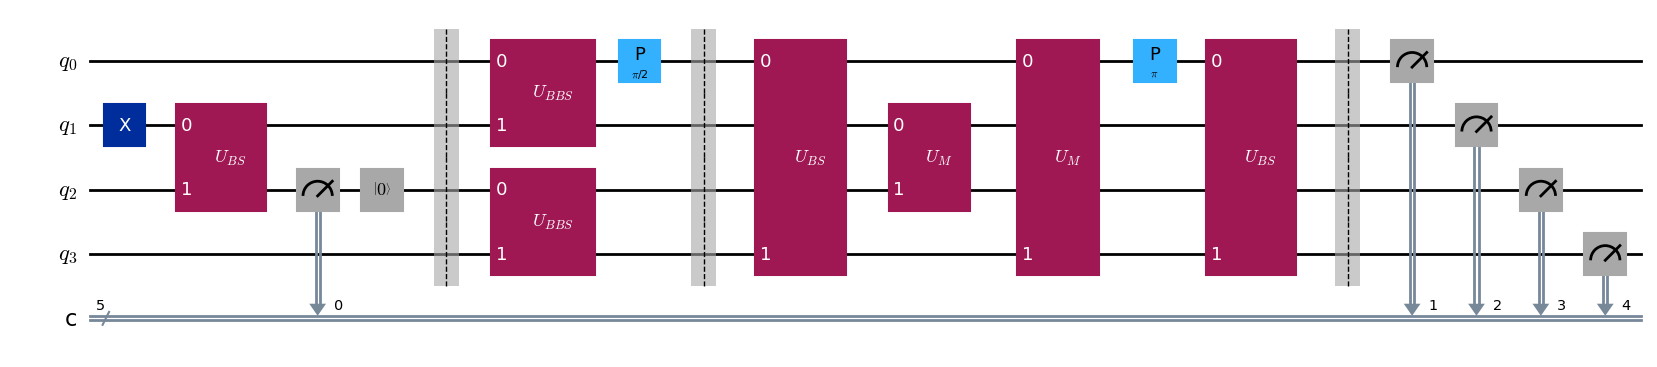

In [7]:
p2 = QuantumCircuit(4, 5)
p2.x(1)
p2.append(beam_splitter(), [[1], [2]]) 
p2.measure(2, 0)
p2.reset(2)
p2.barrier()
p2.append(biased_beam_splitter(0.20131710837464076), [[0], [1]])
p2.append(biased_beam_splitter(0.20131710837464076), [[2], [3]])
p2.p(np.pi/2, 0)
p2.barrier()
p2.append(beam_splitter(), [[0], [3]]) 
p2.append(mirror(), [[1], [2]]) 
p2.append(mirror(), [[0], [3]]) 
p2.p(pi, 0)
p2.append(beam_splitter(), [[0], [3]]) 
p2.barrier()
p2.measure([0, 1, 2, 3], [1, 2, 3, 4])
p2.draw('mpl')

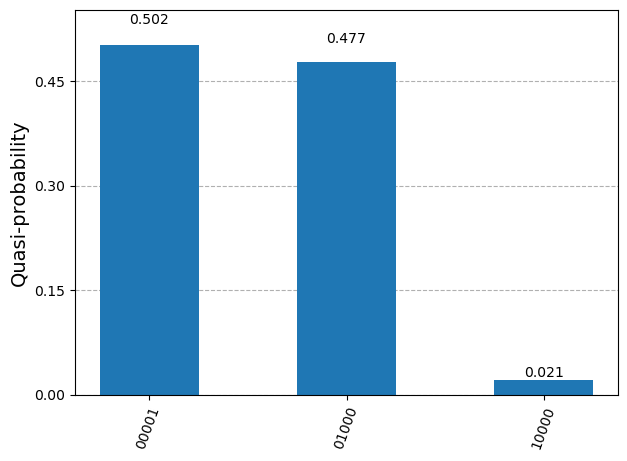

In [13]:
### simulation

sampler = Sampler(mode = simulator) 
sampler.options.default_shots = 2**13
nshots = sampler.options.default_shots 
p2 = transpile(p2, simulator, optimization_level=3)
job_p2 = sampler.run([p2]).result() 
counts_sim_p2 = job_p2[0].data.c.get_counts() 
plot_distribution(counts_sim_p2)

### $p(B_0) = 0.5$
### $p(D_0) = 0.482 + 0.019 = 0.501$  

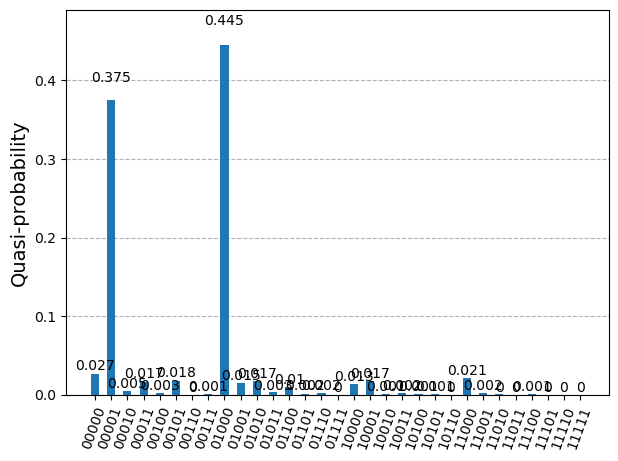

In [14]:
### demonstration

sampler = Sampler(mode=backend)
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.default_shots = 2**13
nshots = sampler.options.default_shots 
job_dem_p2 = sampler.run([transpile(p2, backend, optimization_level=3)]).result()
counts_dem_p2 = job_dem_p2[0].data.c.get_counts() 
plot_distribution(counts_dem_p2)

In [96]:
counts_dem_p2 = {'01000': 3646,
                 '00001': 3068,
                 '00000': 220,
                 '10001': 143,
                 '00101': 145,
                 '11000': 173,
                 '01100': 86,
                 '10000': 108,
                 '01010': 139,
                 '11010': 4,
                 '00011': 136,
                 '01001': 126,
                 '00010': 38,
                 '10011': 15,
                 '01011': 28,
                 '01110': 16,
                 '00100': 21,
                 '01101': 13,
                 '10100': 6,
                 '00111': 7,
                 '10101': 6,
                 '11100': 9,
                 '11011': 2,
                 '00110': 2,
                 '10010': 6,
                 '11001': 20,
                 '11111': 1,
                 '11101': 3,
                 '01111': 3,
                 '11110': 1,
                 '10110': 1}

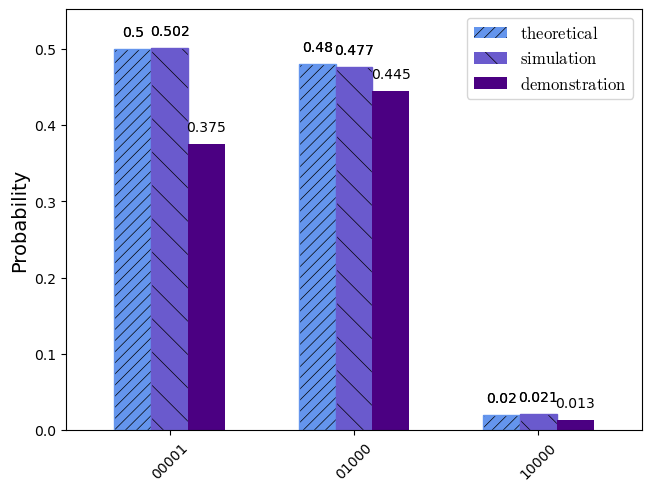

In [16]:
counts_theo_p2 = {'00001': 0.5*2**13, '01000': 0.48*2**13, '10000': 0.02*2**13}

counts_sim_p2 = {'00001': 4111, '01000': 3911, '10000': 170} 

counts_dem_p2_ajusted = {'00001': 3068, '01000': 3646, '10000': 108} 

results(counts_theo_p2, counts_sim_p2, counts_dem_p2_ajusted, 'p2')

#
---
#

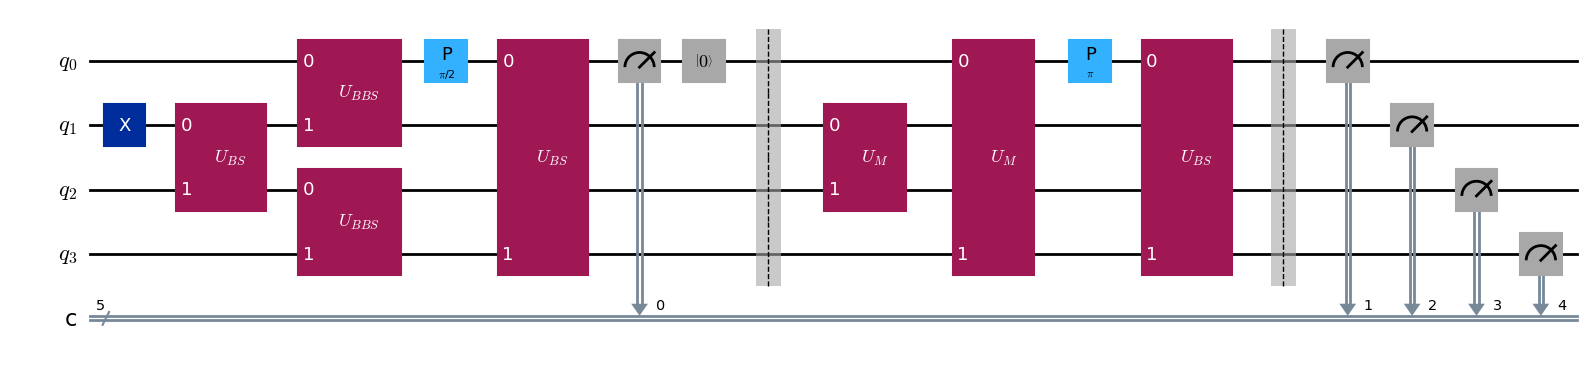

In [38]:
p3 = QuantumCircuit(4, 5)
p3.x(1)
p3.append(beam_splitter(), [[1], [2]]) 
p3.append(biased_beam_splitter(0.20131710837464076), [[0], [1]])
p3.append(biased_beam_splitter(0.20131710837464076), [[2], [3]])
p3.p(np.pi/2, 0)
p3.append(beam_splitter(), [[0], [3]]) 
p3.measure(0,0)
p3.reset(0)
p3.barrier()
p3.append(mirror(), [[1], [2]]) 
p3.append(mirror(), [[0], [3]]) 
p3.p(pi, 0)
p3.append(beam_splitter(), [[0], [3]]) 
p3.barrier()
p3.measure([0, 1, 2, 3], [1, 2, 3, 4])
p3.draw('mpl')

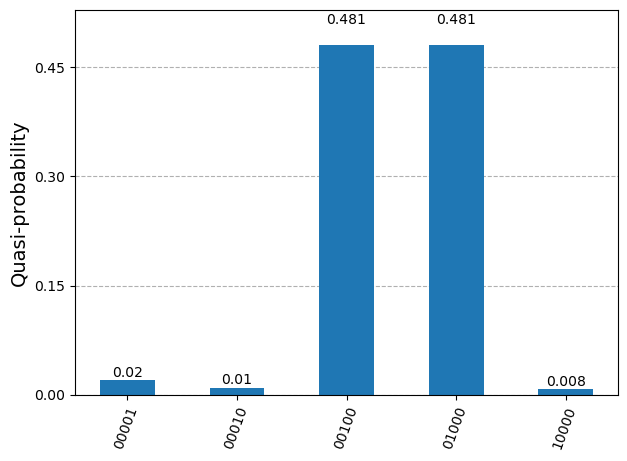

In [37]:
### simulation

sampler = Sampler(mode = simulator) 
sampler.options.default_shots = 2**13
nshots = sampler.options.default_shots 
p3 = transpile(p3, simulator, optimization_level=3)
job_p3 = sampler.run([p3]).result() 
counts_sim_p3 = job_p3[0].data.c.get_counts() 
plot_distribution(counts_sim_p3)

### $p(B_1) = 0.021$
### $p(D_1) = 0.01 + 0.486 = 0.496$
### $p(D_0) = 0.474 + 0.009 = 0.483$

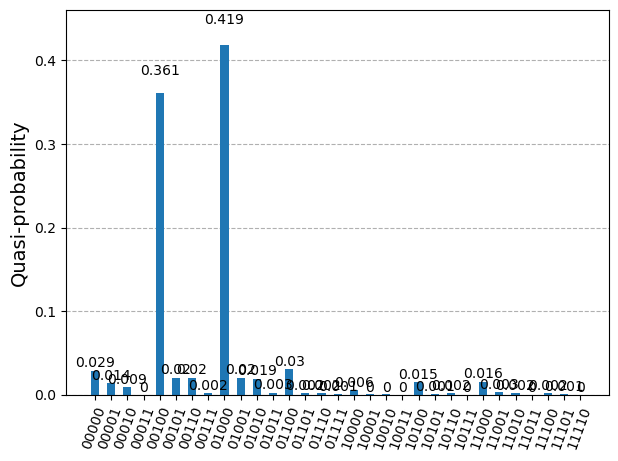

In [39]:
### demonstration

sampler = Sampler(mode=backend)
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.default_shots = 2**13
nshots = sampler.options.default_shots 
job_dem_p3 = sampler.run([transpile(p3, backend, optimization_level=3)]).result()
counts_dem_p3 = job_dem_p3[0].data.c.get_counts() 
plot_distribution(counts_dem_p3)

In [97]:
counts_dem_p3 = {'01000': 3429,
                 '01100': 249,
                 '10101': 11,
                 '00100': 2958,
                 '11001': 23,
                 '01001': 162,
                 '00001': 114,
                 '10100': 124,
                 '00110': 167,
                 '00010': 75,
                 '01011': 21,
                 '10000': 47,
                 '01010': 155,
                 '00000': 235,
                 '00101': 167,
                 '11000': 128,
                 '11010': 16,
                 '00111': 16,
                 '11011': 2,
                 '11101': 6,
                 '01110': 19,
                 '01111': 6,
                 '01101': 17,
                 '10110': 15,
                 '11100': 17,
                 '10010': 3,
                 '10111': 2,
                 '10001': 4,
                 '11110': 1,
                 '00011': 2,
                 '10011': 1}

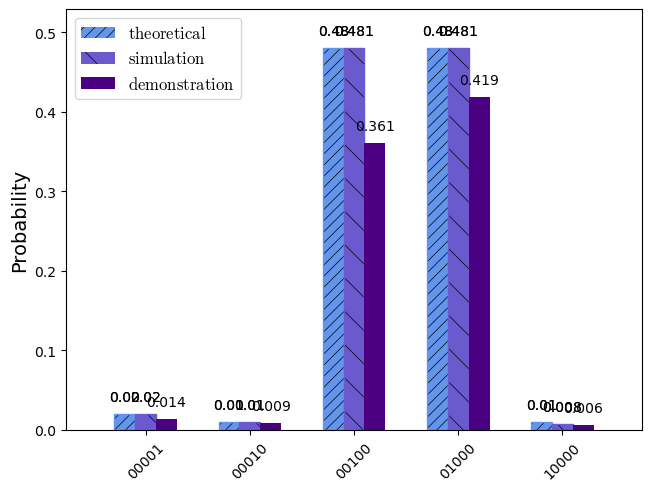

In [17]:
counts_theo_p3 = {'00100': 0.48*2**13, '01000': 0.48*2**13, '00001': 0.02*2**13, '10000': 0.01*2**13, 
                  '00010': 0.01*2**13}

counts_sim_p3 = {'00100': 3940, '01000': 3940, '00001': 164, '10000': 66, '00010': 82}

counts_dem_p3_ajusted = {'00100': 2958, '01000': 3429, '00001': 114, '10000': 47, '00010': 75}

results(counts_theo_p3, counts_sim_p3, counts_dem_p3_ajusted, 'p3')

#
---
#

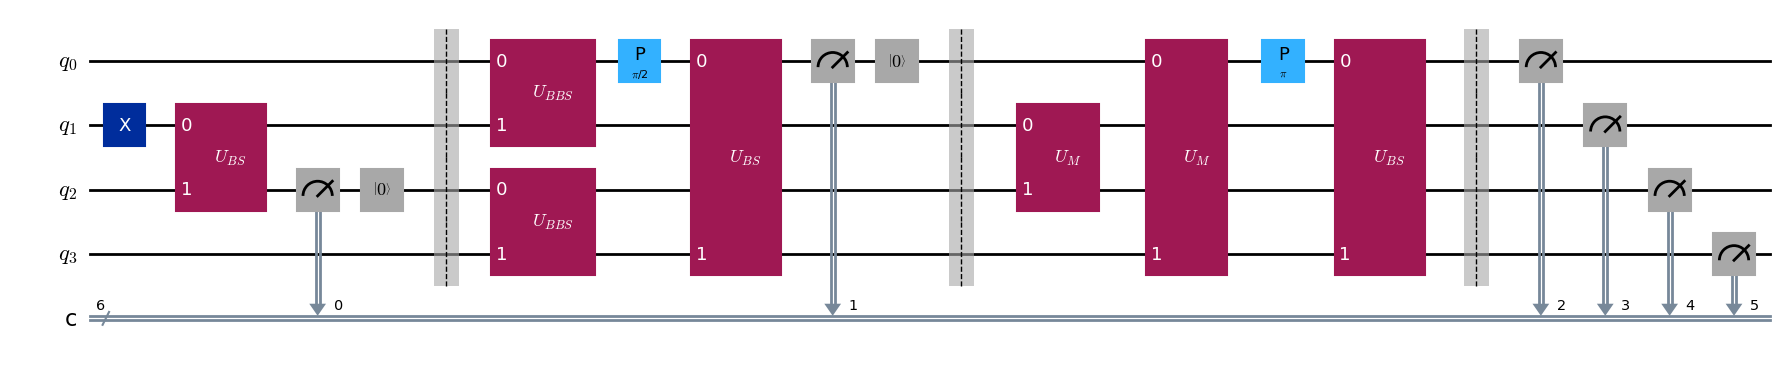

In [46]:
p4 = QuantumCircuit(4, 6)
p4.x(1)
p4.append(beam_splitter(), [[1], [2]]) 
p4.measure(2, 0)
p4.reset(2)
p4.barrier()
p4.append(biased_beam_splitter(0.20131710837464076), [[0], [1]])
p4.append(biased_beam_splitter(0.20131710837464076), [[2], [3]])
p4.p(np.pi/2, 0)
p4.append(beam_splitter(), [[0], [3]]) 
p4.measure(0,1)
p4.reset(0)
p4.barrier()
p4.append(mirror(), [[1], [2]]) 
p4.append(mirror(), [[0], [3]]) 
p4.p(pi, 0)
p4.append(beam_splitter(), [[0], [3]]) 
p4.barrier()
p4.measure([0, 1, 2, 3], [2, 3, 4, 5])
p4.draw('mpl', fold=30)

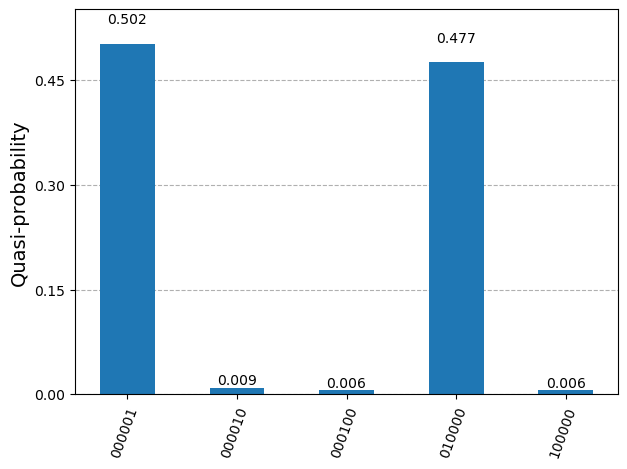

In [48]:
### simulation

sampler = Sampler(mode = simulator) 
sampler.options.default_shots = 2**13
nshots = sampler.options.default_shots 
p4 = transpile(p4, simulator, optimization_level=3)
job_p4 = sampler.run([p4]).result() 
counts_sim_p4 = job_p4[0].data.c.get_counts() 
plot_distribution(counts_sim_p4)

### $p(B_0) = 0.5$
### $p(B_1) = 0.009\ (\sim 1\%)$
### $p(D_1) = 0.004\ (\sim 0.5\%)$
### $p(D_0) = 0.482 + 0.004 = 0.486\ (\sim 48.5\%)$

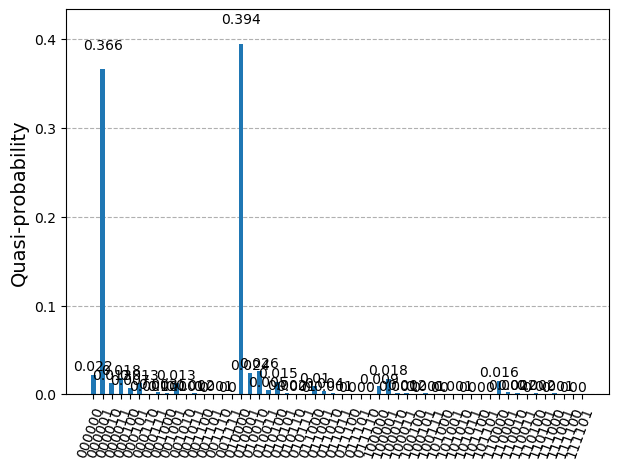

In [52]:
### demonstration

sampler = Sampler(mode=backend)
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.default_shots = 2**13
nshots = sampler.options.default_shots 
job_dem_p4 = sampler.run([transpile(p4, backend, optimization_level=3)]).result()
counts_dem_p4 = job_dem_p4[0].data.c.get_counts() 
plot_distribution(counts_dem_p4)

In [98]:
counts_dem_p4 = {'010000': 3226,
                 '000001': 2996,
                 '101010': 2,
                 '111000': 10,
                 '010010': 214,
                 '110000': 128,
                 '011001': 31,
                 '000000': 179,
                 '001001': 103,
                 '010001': 196,
                 '000011': 149,
                 '100001': 147,
                 '011000': 82,
                 '000101': 110,
                 '000010': 105,
                 '000100': 56,
                 '100000': 77,
                 '110001': 18,
                 '101100': 3,
                 '010100': 119,
                 '010011': 42,
                 '000111': 22,
                 '100010': 12,
                 '001011': 13,
                 '001000': 10,
                 '011011': 4,
                 '100101': 11,
                 '000110': 6,
                 '100011': 16,
                 '110010': 13,
                 '001111': 2,
                 '010101': 13,
                 '001010': 6,
                 '101001': 8,
                 '011100': 2,
                 '110100': 14,
                 '001101': 6,
                 '101000': 4,
                 '010110': 7,
                 '101011': 2,
                 '011101': 1,
                 '011010': 9,
                 '010111': 1,
                 '110011': 4,
                 '111001': 2,
                 '011110': 1,
                 '101101': 1,
                 '111101': 1,
                 '110101': 1,
                 '001100': 3,
                 '100111': 1,
                 '100100': 1,
                 '001110': 1,
                 '111100': 1}

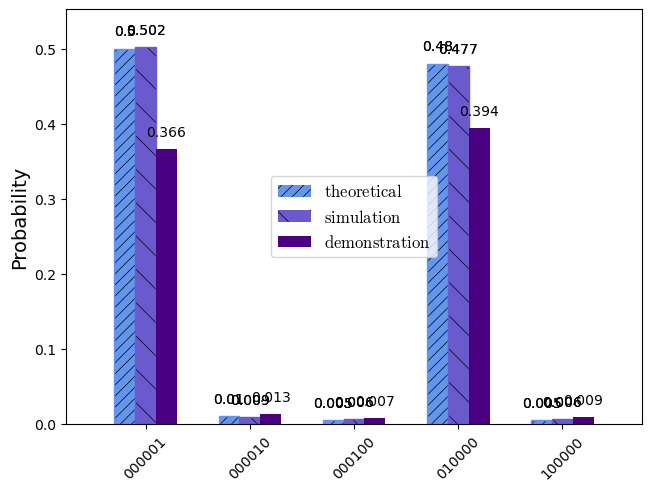

In [18]:
counts_theo_p4 = {'000001': 0.5*2**13, '010000': 0.48*2**13, '000100': 0.005*2**13, 
                  '000010': 0.01*2**13, '100000': 0.005*2**13}

counts_sim_p4 = {'000001': 4109, '010000': 3906, '000100': 53, '000010': 73, '100000': 51}

counts_dem_p4_ajusted = {'000001': 2996, '010000': 3226, '000100': 56, '000010': 105, '100000': 77}

results(counts_theo_p4, counts_sim_p4, counts_dem_p4_ajusted, 'p4')

#
---
#

## Unruh's experiment $-\ \  \phi_E\ $ and $\ \phi_H$

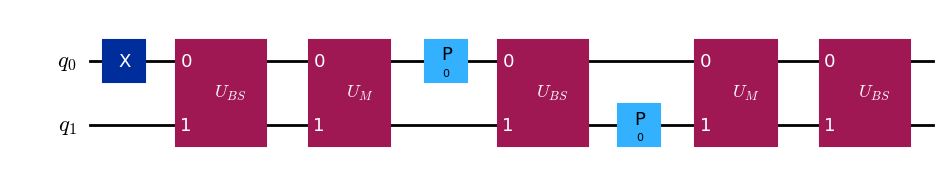

In [7]:
def unruh_phase(ph_1, ph_2):
    qc = QuantumCircuit(2)
    qc.x(0)
    qc.append(beam_splitter(), [[0], [1]])
    qc.append(mirror(), [[0], [1]])
    qc.p(ph_1, 0)
    qc.append(beam_splitter(), [[0], [1]])
    qc.p(ph_2, 1)
    qc.append(mirror(), [[0], [1]])
    qc.append(beam_splitter(), [[0], [1]])
    return qc  
unruh_phase(0, 0).draw('mpl')

In [14]:
def prob(job_list:list) -> list:

    result_total = []
    for j in job_list:
        result_total.append(service.job(j).result()[0].data.c.get_counts())   
    
    prob0 = []
        
    for j in range(len(result_total)):
        if '10' in result_total[j]:
            prob0.append(result_total[j]['10']/nshots)

    return prob0

In [10]:
### simulation

ph = arange(0, 2*np.pi+2*np.pi/19, 2*np.pi/19)
PD0_sim1 = zeros(ph.shape[0])

sampler = Sampler(mode=simulator)
sampler.options.default_shots = 2**13
nshots = sampler.options.default_shots 

for k in range(0, len(ph)):
    qc = QuantumCircuit(2, 2)
    qc.append(unruh_phase(pi/2, ph[k]), [[0], [1]])
    qc.measure([0, 1], [0, 1])
    job_sim1 = sampler.run([transpile(qc, simulator, optimization_level=1)]).result()
    counts_sim1 = job_sim1[0].data.c.get_counts() 
    if '10' in counts_sim1:
        PD0_sim1[k] = counts_sim1['10']/nshots

PD0_sim1 = [0.50244141, 0.65087891, 0.8034668 , 0.92285156, 0.98510742,
            0.99755859, 0.96130371, 0.85961914, 0.74560547, 0.57763672,
            0.41662598, 0.26159668, 0.13330078, 0.04187012, 0.00170898,
            0.0144043 , 0.0814209 , 0.19042969, 0.34033203, 0.49902344]

PD0_sim2 = zeros(ph.shape[0])

sampler = Sampler(mode=simulator)
sampler.options.default_shots = 2**13
nshots = sampler.options.default_shots 

for k in range(0, len(ph)):
    qc = QuantumCircuit(2, 2)
    qc.append(unruh_phase(ph[k], 0), [[0], [1]])
    qc.measure([0, 1], [0, 1])
    job_sim2 = sampler.run([transpile(qc, simulator, optimization_level=1)]).result()
    counts_sim2 = job_sim2[0].data.c.get_counts() 
    if '10' in counts_sim2:
        PD0_sim2[k] = counts_sim2['10']/nshots

PD0_sim2 = [0.50732422, 0.5098877 , 0.50415039, 0.50158691, 0.4942627 ,
            0.49072266, 0.49438477, 0.49536133, 0.49890137, 0.49975586,
            0.5032959 , 0.50305176, 0.5020752 , 0.49267578, 0.49291992,
            0.49743652, 0.50415039, 0.49389648, 0.49865723, 0.50195312]

In [12]:
### demonstration

# ph = arange(0, 2*pi+2*pi/19, 2*pi/19)

# PD0_1 = zeros(ph.shape[0])

# options = SamplerOptions(environment={"job_tags": ["job_1"]})
# sampler = Sampler(mode=backend, options=options)

# sampler.options.default_shots = 2**13

# nshots = sampler.options.default_shots 

# job_1_ids = []

# for k in range(0, len(ph)):
#     qc = QuantumCircuit(2, 2)
#     qc.append(unruh_phase(np.pi/2, ph[k]), [[0], [1]])
#     qc.measure([0, 1], [0, 1])
#     job_1 = sampler.run([transpile(qc, backend, optimization_level=1)])
#     job_1_ids.append(job_1.job_id())
#     result_1 = job_1.result()
#     counts_1 = result_1[0].data.c.get_counts()
#     if '10' in counts_1:
#         PD0_1[k] = counts_1['10']/nshots  

In [23]:
# P_1 = prob(['cxdfwdsky7rg008ts0gg',
#          'cxdfx3cgcckg008bh1kg',
#          'cxdfytbfdnwg008s0z3g',
#          'cxdfzzfvw7kg008atw1g',
#          'cxdg2n23ej4g0089xfg0',
#          'cxdg2z36t010008catk0',
#          'cxdg440gcckg008bh36g',
#          'cxdg6yvfdnwg008s10r0',
#          'cxdg8e1fdnwg008s1150',
#          'cxdg8m2ky7rg008ts3jg',
#          'cxdgb8dfdnwg008s1260',
#          'cxdgbkefdnwg008s12a0',
#          'cxdgczkgcckg008bh5tg',
#          'cxdgd6mgcckg008bh5wg',
#          'cxdgeykgcckg008bh6a0',
#          'cxdggb9gcckg008bh6k0',
#          'cxdgjpafdnwg008s13s0',
#          'cxdgnv73ej4g0089xkb0',
#          'cxdgvh6ky7rg008ts68g',
#          'cxdgw1r3ej4g0089xkr0'])

In [38]:
P_1 = [  0.4051513671875,
         0.5533447265625,
         0.6380615234375,
         0.71533203125,
         0.784423828125,
         0.76025390625,
         0.737548828125,
         0.6951904296875,
         0.615234375,
         0.5692138671875,
         0.4407958984375,
         0.291748046875,
         0.17724609375,
         0.1026611328125,
         0.0413818359375,
         0.0322265625,
         0.07763671875,
         0.185302734375,
         0.31005859375,
         0.4508056640625]

In [24]:
# P_2 = prob(['cxdh3c56t010008cazr0',
#           'cxdh4hafdnwg008s15m0',
#           'cxdhb0wfdnwg008s16xg',
#           'cxdhc3rvw7kg008av440',
#           'cxdhdpp6t010008cb1zg',
#           'cxdhe3gfdnwg008s17m0',
#           'cxdhfhy6t010008cb2b0',
#           'cxdhg6gky7rg008ts9sg',
#           'cxdhkjegcckg008bhcv0',
#           'cxdhng66t010008cb3r0',
#           'cxdhrjt6t010008cb4fg',
#           'cxdhvedgcckg008bhfag',
#           'cxdhyf9vw7kg008av91g',
#           'cxdhzcx6t010008cb6b0',
#           'cxdj3m6gcckg008bhhq0',
#           'cxdj410ky7rg008tsey0',
#           'cxdj6z33ej4g0089xxgg',
#           'cxdj9xq3ej4g0089xyf0',
#           'cxdja286t010008cb9a0',
#           'cxdjcnt6t010008cba6g'])

In [34]:
P_2 = [0.4254150390625,
       0.5726318359375,
       0.69384765625,
       0.777587890625,
       0.8648681640625,
       0.88330078125,
       0.82763671875,
       0.798828125,
       0.7099609375,
       0.5703125,
       0.437255859375,
       0.294921875,
       0.1688232421875,
       0.08642578125,
       0.0333251953125,
       0.0570068359375,
       0.0877685546875,
       0.1763916015625,
       0.28369140625,
       0.423583984375]

In [25]:
# P_3 = prob(['cxdkp6r3ej4g0089yb90',
#          'cxdkqed3ej4g0089ybjg',
#          'cxdkyh2gcckg008j9cc0',
#          'cxdkzan3ej4g0089ydv0',
#          'cxdm260ky7rg0083ksf0',
#          'cxdm3kyky7rg0083kt00',
#          'cxdm5956t010008cbrz0',
#          'cxdm6qjvw7kg00803dz0',
#          'cxdmap2ky7rg0083kvbg',
#          'cxdmav3fdnwg008s209g',
#          'cxdmdfxky7rg0083kvtg',
#          'cxdmdpyvw7kg00803ewg',
#          'cxdmdxqfdnwg008s20p0',
#          'cxdme40ky7rg0083kvx0',
#          'cxdmebh3ej4g008ftkw0',
#          'cxdmet3gcckg008s3xs0',
#          'cxdmf44fdnwg008s20r0',
#          'cxdmfbn3ej4g008ftkyg',
#          'cxdmp4g6t010008cbv40',
#          'cxdmpasgcckg008s3yfg'])

In [37]:
P_3 = [ 0.460693359375,
        0.5958251953125,
        0.711669921875,
        0.799072265625,
        0.8480224609375,
        0.8262939453125,
        0.8179931640625,
        0.7371826171875,
        0.6461181640625,
        0.52294921875,
        0.4083251953125,
        0.2587890625,
        0.170654296875,
        0.074951171875,
        0.0501708984375,
        0.0560302734375,
        0.1207275390625,
        0.192138671875,
        0.3065185546875,
        0.4334716796875]

In [26]:
# P_4 = prob(['cxd5z1wpjw30008g32g0',
#          'cxd98sbztp30008bn7rg',
#          'cxd9e60tpsjg0083mhe0',
#          'cxd9eqjpx23g008t7w70',
#          'cxd9fentpsjg0083mhmg',
#          'cxd9ntfpx23g008t7x50',
#          'cxd9pktrkac0008hq00g',
#          'cxd9q2cbqkhg008kepp0',
#          'cxd9qgptpsjg0083mjjg',
#          'cxd9qyqtpsjg0083mjn0',
#          'cxd9rzkpjw30008g3a60',
#          'cxd9syfztp30008bn9eg',
#          'cxd9tt3ztp30008bn9j0',
#          'cxd9v64tpsjg0083mk20',
#          'cxd9vjppx23g008t7xs0',
#          'cxd9vs7pjw30008g3ag0',
#          'cxd9wcspjw30008g3ahg',
#          'cxd9xextpsjg0083mk9g',
#          'cxd9y99rkac0008hq0zg',
#          'cxd9ytkrkac0008hq120'])

In [32]:
P_4 = [0.4652099609375,
       0.578369140625,
       0.679443359375,
       0.8887939453125,
       0.8988037109375,
       0.9730224609375,
       0.9365234375,
       0.8380126953125,
       0.7183837890625,
       0.567138671875,
       0.38427734375,
       0.25244140625,
       0.1217041015625,
       0.0367431640625,
       0.0035400390625,
       0.0135498046875,
       0.0738525390625,
       0.1788330078125,
       0.330322265625,
       0.4764404296875]

In [27]:
# P_5 = prob(['cxd9z64bqkhg008keqng',
#          'cxda3dnpx23g008t7ys0',
#          'cxda3mprkac0008hq1f0',
#          'cxda458tpsjg0083mkz0',
#          'cxda4vvztp30008bnas0',
#          'cxda52cpx23g008t7yz0',
#          'cxda5axztp30008bnat0',
#          'cxda5kyztp30008bnatg',
#          'cxda5yfbqkhg008kerf0',
#          'cxda6gtpjw30008g3bg0',
#          'cxda6z3px23g008t7z3g',
#          'cxda744ztp30008bnayg',
#          'cxda795bqkhg008kerj0',
#          'cxda7h6pjw30008g3bpg',
#          'cxdcshyrkac0008hqd3g',
#          'cxdcttkpx23g008t8acg',
#          'cxdcv1wztp30008bnnvg',
#          'cxdcv8xtpsjg0083mz4g',
#          'cxdcvg6tpsjg0083mz70',
#          'cxdcvwqpx23g008t8amg'])

In [31]:
P_5 = [0.4656982421875,
       0.610107421875,
       0.7838134765625,
       0.8818359375,
       0.950927734375,
       0.9476318359375,
       0.8829345703125,
       0.830322265625,
       0.7088623046875,
       0.5528564453125,
       0.3841552734375,
       0.2391357421875,
       0.1190185546875,
       0.0379638671875,
       0.002197265625,
       0.0128173828125,
       0.071044921875,
       0.17626953125,
       0.3155517578125,
       0.4803466796875]

In [40]:
def statistics(X, n) -> float: 
    sum_X = 0    
    for j in range(0, n):
        sum_X = sum_X + float(X[j])
        
    sum_X_sq = 0  
    for j in range(0, n):
        sum_X_sq = sum_X_sq + float(X[j])**2

    X_medio = sum_X/n  
    
    X_sq_medio = sum_X_sq/n   

    desvio_padrao_X = np.std(X)/ np.sqrt(n)
    
    # desvio_padrao_X = np.sqrt(X_sq_medio - X_medio**2) / np.sqrt(n)    

    return X_medio, desvio_padrao_X

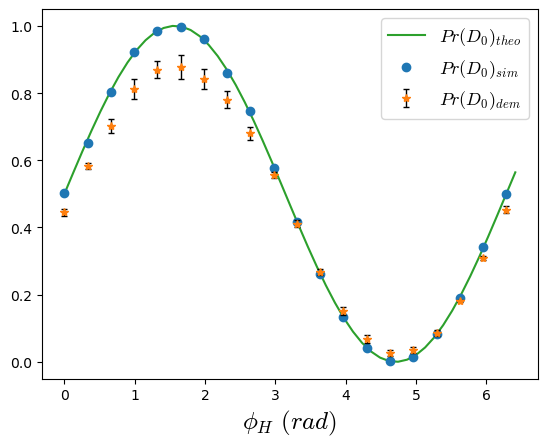

In [67]:
probs_1 = [P_1, P_2, P_3,  P_4,  P_5]

pontos_1 = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
for j in range(len(P_1)):
    for k in range(len(probs_1)):
        pontos_1[j].append(probs_1[k][j])

media_1 = []     
for j in pontos_1:
    media_1.append(estatistica(j, len(probs_1))[0])

error_1 = []
for j in pontos_1:
    error_1.append(estatistica(j, len(probs_1))[1])   

ph_theo_1 = arange(0, 2*pi+2*pi/49, 2*pi/49)

theo_1 = []
for j in ph_theo_1:
    theo_1.append((1+np.sin(j))/2)

plt.rcParams['mathtext.fontset'] = 'cm'

plt.plot(ph_theo_1, theo_1, '-', markersize=5, label=r'$Pr(D_0)_{theo}$', scaley=False, color='tab:green')

plt.plot(ph, PD0_sim1, 'o', markersize=6, label=r'$Pr(D_0)_{sim}$', scaley=False, color='tab:blue')

plt.errorbar(ph, media_1, yerr=error_1, fmt='*', markersize=6, label=r'$Pr(D_0)_{dem}$', color='tab:orange', 
             ecolor='black', capsize=2, elinewidth=1) 

plt.ylim(-0.05, 1.05)

plt.legend(prop={'size': 13})

#plt.ylabel('Probability', size=15)

plt.xlabel(r'$\phi_H\ (rad)$', size=18) 

plt.show()

In [68]:
# P_6 = prob(['cxj48ehky7rg00845yyg',
#              'cxj4czvky7rg00845zf0',
#              'cxj4j58ky7rg00846010',
#              'cxj4q9d3ej4g008gcqyg',
#              'cxj4v9nvw7kg008sd7w0',
#              'cxj50d1gcckg008sngeg',
#              'cxj55sf3ej4g008gcsxg',
#              'cxj59z7gcckg008snhjg',
#              'cxj5e1gfdnwg008skz4g',
#              'cxj5k9xvw7kg008sdamg',
#              'cxj5rs36t010008cxx4g',
#              'cxj5xzfvw7kg008sdbjg',
#              'cxj64bhvw7kg008sdcm0',
#              'cxj68ma3ej4g008gcxb0',
#              'cxj6fc5gcckg008snmvg',
#              'cxj6hfngcckg008snmxg',
#              'cxj6pb13ej4g008gcyb0',
#              'cxj6v4mvw7kg008sde2g',
#              'cxj70wk3ej4g008gcyxg',
#              'cxj7504ky7rg008467p0'])

In [69]:
P_6 = [0.436279296875,
     0.4193115234375,
     0.3961181640625,
     0.3753662109375,
     0.4443359375,
     0.4237060546875,
     0.4326171875,
     0.436767578125,
     0.4404296875,
     0.442626953125,
     0.4244384765625,
     0.4190673828125,
     0.4295654296875,
     0.438232421875,
     0.4315185546875,
     0.44482421875,
     0.4041748046875,
     0.4334716796875,
     0.4080810546875,
     0.3817138671875]

In [70]:
# P_7 = prob(['cxj7sc53ej4g008gd1dg',
#             'cxj7vme6t010008cy37g',
#             'cxj81fn3ej4g008gd280',
#             'cxj856wfdnwg008sm6sg',
#             'cxj898xky7rg00846az0',
#             'cxj8eg2ky7rg00846bf0',
#             'cxj8jd1ky7rg00846c0g',
#             'cxj8n9xgcckg008snv6g',
#             'cxj8teh3ej4g008gd4s0',
#             'cxj8yj2fdnwg008sm9n0',
#             'cxj92n2ky7rg00846eyg',
#             'cxj98kt6t010008cy9w0',
#             'cxj9ebhgcckg008sp120',
#             'cxj9mf9gcckg008sp2t0',
#             'cxj9p3g3ej4g008gddb0',
#             'cxj9v0wfdnwg008smhs0',
#             'cxj9ze5ky7rg00846qk0', 
#             'cxja2a93ej4g008gdgjg',
#             'cxja55c6t010008cygy0',
#             'cxja5jegcckg008sp630'])

In [71]:
P_7 = [0.3892822265625,
     0.3985595703125,
     0.4114990234375,
     0.4193115234375,
     0.4287109375,
     0.4208984375,
     0.4290771484375,
     0.4403076171875,
     0.4178466796875,
     0.4124755859375,
     0.422607421875,
     0.43212890625,
     0.4234619140625,
     0.435546875,
     0.410400390625,
     0.4376220703125,
     0.4385986328125,
     0.4091796875,
     0.3946533203125,
     0.4320068359375]

In [72]:
# P_8 = prob(['cxjy0nafdnwg008spjc0',
#             'cxjy5fdgcckg008sr2rg',
#             'cxjy9pegcckg008sr3p0',
#             'cxjyeb1vw7kg008sfxs0',
#             'cxjyk7wfdnwg008spm3g',
#             'cxjys0mfdnwg008spnb0',
#             'cxjywdhfdnwg008spp70',
#             'cxjz0pa3ej4g008gfm80',
#             'cxjz5qp6t010008d0m2g',
#             'cxjzaf13ej4g008gfmqg',
#             'cxjzeptfdnwg008spqbg',
#             'cxjzm0g3ej4g008gfn8g',
#             'cxjzr0rky7rg00848wzg',
#             'cxjzwahky7rg00848x70',
#             'cxk0091ky7rg00848xcg',
#             'cxk0460fdnwg008spt6g',
#             'cxk08706t010008d0qr0',
#             'cxk0dgeky7rg0084900g',
#             'cxk0dppky7rg00849020',
#             'cxk0gm2gcckg008srba0'])

In [73]:
P_8 = [0.3843994140625,
     0.4036865234375,
     0.3563232421875,
     0.35400390625,
     0.4208984375,
     0.3660888671875,
     0.401611328125,
     0.4207763671875,
     0.4420166015625,
     0.466552734375,
     0.46728515625,
     0.4368896484375,
     0.4349365234375,
     0.4757080078125,
     0.464599609375,
     0.4542236328125,
     0.4703369140625,
     0.446533203125,
     0.4241943359375,
     0.40771484375]

In [74]:
# P_9 = prob(['cxk1z956t010008d0vy0',
#              'cxk2489fdnwg008spyrg',
#              'cxk25n6vw7kg008sg8y0',
#              'cxk29exgcckg008srfgg',
#              'cxk29tqgcckg008srfh0',
#              'cxk2dp6vw7kg008sg9bg',
#              'cxk2f446t010008d0wpg',
#              'cxk2kcn6t010008d0x2g',
#              'cxk2q9x3ej4g008gfxk0',
#              'cxk2t1gky7rg00849570',
#              'cxk2y58vw7kg008sga9g',
#              'cxk3250fdnwg008sq0a0',
#              'cxk36996t010008d0y1g',
#              'cxk3ac93ej4g008gfyh0',
#              'cxk3ektgcckg008srh10',
#              'cxk3mntgcckg008srhb0',
#              'cxk3v04fdnwg008sq1hg',
#              'cxk3ven3ej4g008gfzhg',
#              'cxk41pe3ej4g008gg060',
#              'cxk42bh6t010008d0zqg'])

In [75]:
P_9 = [0.41650390625,
     0.3817138671875,
     0.424072265625,
     0.4228515625,
     0.455322265625,
     0.443603515625,
     0.4696044921875,
     0.4422607421875,
     0.492919921875,
     0.47216796875,
     0.473876953125,
     0.462646484375,
     0.4031982421875,
     0.40234375,
     0.4425048828125,
     0.4171142578125,
     0.4222412109375,
     0.345458984375,
     0.379638671875,
     0.3402099609375]

In [76]:
# P_10 = prob(['cxk4k0m6t010008d1190',
#              'cxk4qmp3ej4g008gg23g',
#              'cxk4xpyvw7kg008sgegg',
#              'cxk4zn6ky7rg008499ng',
#              'cxk58e93ej4g008gg2pg',
#              'cxk5a3rky7rg00849a2g',
#              'cxk5hmygcckg008srn20',
#              'cxk5mvvky7rg00849an0',
#              'cxk5tmjky7rg00849atg',
#              'cxk5xq63ej4g008gg3v0',
#              'cxk61n6ky7rg00849b7g',
#              'cxk63h6fdnwg008sq610',
#              'cxk69yzfdnwg008sq66g',
#              'cxk6gds3ej4g008gg4vg',
#              'cxk6gqafdnwg008sq6g0',
#              'cxk6qax3ej4g008gg5h0',
#              'cxk6w913ej4g008gg5z0',
#              'cxk6zwqgcckg008srr3g',
#              'cxk739xky7rg00849dx0',
#              'cxk750wvw7kg008sgk80'])

In [77]:
P_10 = [0.429931640625,
         0.3519287109375,
         0.42041015625,
         0.424560546875,
         0.4444580078125,
         0.4447021484375,
         0.441650390625,
         0.4852294921875,
         0.501953125,
         0.4892578125,
         0.4805908203125,
         0.4625244140625,
         0.46875,
         0.455810546875,
         0.451171875,
         0.439697265625,
         0.4315185546875,
         0.4219970703125,
         0.4124755859375,
         0.392333984375]

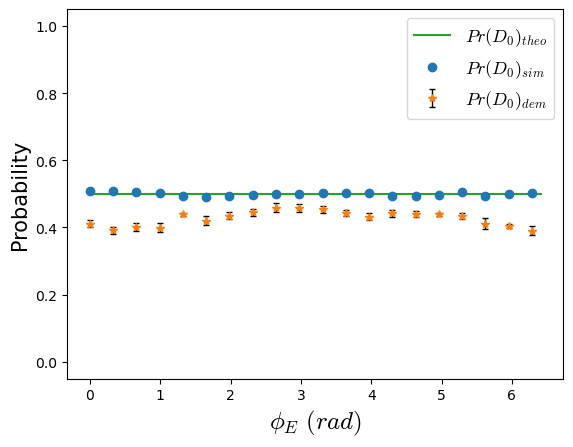

In [78]:
probs_2 = [P_6, P_7, P_8, P_9, P_10]

pontos_2 = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
for j in range(len(P_6)):
    for k in range(len(probs_2)):
        pontos_2[j].append(probs_2[k][j])

media_2 = []     
for j in pontos_2:
    media_2.append(estatistica(j, len(probs_2))[0])

error_2 = []
for j in pontos_2:
    error_2.append(estatistica(j, len(probs_2))[1])  

ph_theo_2 = arange(0, 2*pi+2*pi/49, 2*pi/49)

theo_2 = []
for j in ph_theo_2:
    theo_2.append(0.5)

plt.rcParams['mathtext.fontset'] = 'cm'

plt.plot(ph_theo_2, theo_2, '-', markersize=5, label=r'$Pr(D_0)_{theo}$', scaley=False, color='tab:green')

plt.plot(ph, PD0_sim2, 'o', markersize=6, label=r'$Pr(D_0)_{sim}$', scaley=False, color='tab:blue')

plt.errorbar(ph, media_2, yerr=error_2, fmt='*', markersize=6, label=r'$Pr(D_0)_{dem}$', color='tab:orange', 
             ecolor='black', capsize=2, elinewidth=1) 

plt.ylim(-0.05, 1.05)

plt.legend(prop={'size': 13})

plt.ylabel('Probability', size=15)

plt.xlabel(r'$\phi_E\ (rad)$', size=18) 

plt.show()

#
---
#